# Beta Neutral Crypto Portfolio

In [3]:
# import dependencies

import pandas as pd
import numpy as np
import os
from typing import List
import cvxpy as cp



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/chriskang/Library/Caches/pypoetry/virtualenvs/quant-playground-PXu2n-Lk-py3.12/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/chriskang/Library/Caches/pypoetry/virtualenvs/quant-playground-PXu2n-Lk-py3.12/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/chriska

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



(CVXPY) Jun 29 04:26:33 PM: Encountered unexpected exception importing solver OSQP:
ImportError('numpy.core.multiarray failed to import')


## 1. Raw Data Preparation


In [4]:
# Constants
DATA_PATH = "/Users/chriskang/Desktop/Projects/SideQuant/PxDataDownloader/data"

In [5]:
# function for data loading

def list_universe():
    f_list: List[str] = os.listdir(DATA_PATH)
    symbols = [f.split('.')[0] for f in f_list if f.endswith('.parquet') and not '_' in f and 'USDT' in f]
    symbols = sorted(symbols)
    return symbols

def load_data(symbol: str, interval: str):
    target_data_path = os.path.join(DATA_PATH, f'{symbol}.parquet')
    data = pd.read_parquet(target_data_path)
    data = data[data['interval'] == interval]
    data = data.reset_index(drop=True)
    return data

def prep_many_data(symbols: List[str], interval: str):
    data = {}
    for symbol in symbols:
        df = load_data(symbol, interval)
        if len(df) < 1000:
            continue
        data[symbol] = df 
    return data
    

In [6]:
# load universe data in the kernal
all_symbols = list_universe()
raw_data = prep_many_data(all_symbols, '4h')

# 2. Data Processing

### A. Symbol Selection Criteria


In [7]:
# Top 100 symbols with highest quote(USDT) volume

# can add more filters to the universe
quote_volume = {}
for symbol, df in raw_data.items():
    quote_volume[symbol] = df['quote_volume'].rolling(window=42).mean().iloc[-1]  # weekly average 168/4 = 42 hrs
quote_volume = pd.Series(quote_volume)
quote_volume = quote_volume.sort_values(ascending=False)
quote_volume = quote_volume[:100]
target_symbols = quote_volume.index.tolist()

## Compute Returns

- using close price to compute return does not resemble real market scenario
- here I used ohlc/4 (for more realistic execution price)

In [8]:
raw_data["BTCUSDT"].head()

,symbol,interval,open_ts,open,high,low,close,volume,close_ts,quote_volume,num_trades,taker_buy_base_vol,taker_buy_quote_vol
0,BTCUSDT,4h,2019-09-25 08:00:00,8325.28,8546.73,8215.00,8327.38,7480.944,2019-09-25 11:59:59,6.237703e+07,17165,3882.846,3.238099e+07
1,BTCUSDT,4h,2019-09-25 12:00:00,8324.27,8460.00,8242.61,8293.28,9081.314,2019-09-25 15:59:59,7.596230e+07,16760,4556.868,3.811946e+07
2,BTCUSDT,4h,2019-09-25 16:00:00,8295.79,8408.31,8223.71,8346.96,6397.273,2019-09-25 19:59:59,5.330385e+07,12250,3143.741,2.619283e+07
3,BTCUSDT,4h,2019-09-25 20:00:00,8346.96,8628.44,8332.41,8430.07,9155.947,2019-09-25 23:59:59,7.757005e+07,11781,5167.462,4.380190e+07
4,BTCUSDT,4h,2019-09-26 00:00:00,8428.15,8443.55,8316.61,8361.80,4251.146,2019-09-26 03:59:59,3.561040e+07,6539,2272.952,1.903701e+07


In [9]:
returns = pd.DataFrame()

for symbol, df in raw_data.items():
    new_price = (df['close'] + df['open'] + df['high'] + df['low']) / 4
    tmp_return_df = new_price.pct_change().dropna().to_frame(name=symbol)
    tmp_return_df.set_index(df['open_ts'].iloc[1:], inplace=True)
    returns = pd.merge(returns, tmp_return_df, how='outer', left_index=True, right_index=True)
returns = returns[target_symbols].dropna()
returns = returns.T.sort_index().T

print(returns.head())
print(returns.tail())


                     1000BONKUSDT  1000FLOKIUSDT  1000LUNCUSDT  1000PEPEUSDT  \
open_ts                                                                        
2023-12-15 20:00:00     -0.090486      -0.009255     -0.017564     -0.014592   
2023-12-16 00:00:00     -0.071523      -0.014080     -0.012994     -0.005336   
2023-12-16 04:00:00      0.015848       0.013800      0.006972      0.022256   
2023-12-16 08:00:00     -0.030681       0.027496      0.010572      0.032994   
2023-12-16 12:00:00      0.026590       0.010216      0.012215      0.013852   

                     1000RATSUSDT  1000SATSUSDT  1000SHIBUSDT  AAVEUSDT  \
open_ts                                                                   
2023-12-15 20:00:00     -0.012698     -0.028518     -0.006632 -0.007526   
2023-12-16 00:00:00     -0.132097     -0.036417     -0.004769 -0.023226   
2023-12-16 04:00:00     -0.015177      0.007566      0.017328 -0.009739   
2023-12-16 08:00:00      0.017466      0.001844      0.013239 -0

Prepare train and test return data

In [25]:
train_return_df = returns.reset_index().loc[len(returns)-1000:len(returns)-500].iloc[:-1].set_index('open_ts')
test_return_df = returns.reset_index().loc[len(returns)-500:].set_index('open_ts')
full_return_df = pd.concat([train_return_df, test_return_df])

print(f"train_return_df {train_return_df.shape}")
print(train_return_df['BTCUSDT'].tail())
print(f"test_return_df {test_return_df.shape}")
print(test_return_df['BTCUSDT'].head())

train_return_df (500, 100)
open_ts
2024-03-23 08:00:00    0.006835
2024-03-23 12:00:00    0.004792
2024-03-23 16:00:00    0.005095
2024-03-23 20:00:00   -0.011088
2024-03-24 00:00:00   -0.005020
Name: BTCUSDT, dtype: float64
test_return_df (500, 100)
open_ts
2024-03-24 04:00:00    0.001318
2024-03-24 08:00:00    0.011097
2024-03-24 12:00:00    0.009035
2024-03-24 16:00:00    0.000295
2024-03-24 20:00:00    0.016228
Name: BTCUSDT, dtype: float64


# 3. Optimization

In [26]:
# return data to use for optimization, last 1000 data points
Sigma = train_return_df.cov()
Sigma.head()

,1000BONKUSDT,1000FLOKIUSDT,1000LUNCUSDT,1000PEPEUSDT,1000RATSUSDT,1000SATSUSDT,1000SHIBUSDT,AAVEUSDT,ADAUSDT,AGIXUSDT,...,TOKENUSDT,TRBUSDT,TRUUSDT,TRXUSDT,UNIUSDT,WAVESUSDT,WLDUSDT,XMRUSDT,XRPUSDT,YGGUSDT
1000BONKUSDT,0.000992,0.000581,0.000359,0.000656,0.000557,0.000407,0.000487,0.000216,0.000274,0.000247,...,0.000368,0.000283,0.000288,0.000061,0.000200,0.000289,0.000258,0.000095,0.000183,0.000216
1000FLOKIUSDT,0.000581,0.001129,0.000320,0.000773,0.000492,0.000377,0.000514,0.000203,0.000230,0.000261,...,0.000574,0.000263,0.000278,0.000055,0.000221,0.000249,0.000278,0.000114,0.000159,0.000185
1000LUNCUSDT,0.000359,0.000320,0.000485,0.000304,0.000343,0.000267,0.000274,0.000174,0.000184,0.000213,...,0.000323,0.000233,0.000208,0.000046,0.000170,0.000202,0.000215,0.000091,0.000130,0.000163
1000PEPEUSDT,0.000656,0.000773,0.000304,0.000996,0.000513,0.000386,0.000484,0.000219,0.000244,0.000251,...,0.000452,0.000241,0.000255,0.000058,0.000223,0.000274,0.000240,0.000119,0.000170,0.000166
1000RATSUSDT,0.000557,0.000492,0.000343,0.000513,0.000949,0.000536,0.000449,0.000228,0.000244,0.000261,...,0.000392,0.000314,0.000291,0.000064,0.000189,0.000247,0.000308,0.000108,0.000171,0.000220


In [27]:
betas = Sigma['BTCUSDT'] / Sigma.loc['BTCUSDT', 'BTCUSDT']
betas.drop('BTCUSDT', inplace=True)
betas = betas.sort_index()
print(betas.shape)
betas.head()

(99,)


1000BONKUSDT     2.044593
1000FLOKIUSDT    1.745877
1000LUNCUSDT     1.224443
1000PEPEUSDT     1.973515
1000RATSUSDT     1.764258
Name: BTCUSDT, dtype: float64

In [28]:
train_return_df.drop('BTCUSDT', axis=1, inplace=True)  # since we are using BTC as the benchmark
final_Sigma = train_return_df.cov()
final_Sigma.shape

(99, 99)

In [29]:
n = len(train_return_df.columns)
weights = cp.Variable(n)
print(weights.shape, final_Sigma.shape)
pf_var = cp.quad_form(weights, final_Sigma.values)
objective = cp.Minimize(pf_var)

lb = -1
ub = 1
constraints = [
    weights >= lb, 
    weights <= ub, 
    weights.T @ betas == 0,
    # cp.abs(weights) <= 0.05,
    cp.sum(weights) == 1
]

prob = cp.Problem(objective, constraints)
if not prob.is_dcp():
    raise Exception("Problem is not DCP")
prob.solve(solver=cp.CLARABEL)
if prob.status != cp.OPTIMAL:
    raise Exception("Optimization problem is not solvable")

weights = weights.value
print(weights)

(np.int32(99),) (99, 99)
[-4.52553763e-03  1.28776126e-02  8.32297005e-04 -1.21784070e-02
  1.75658145e-02  7.42527227e-04  2.91697938e-02 -6.09874292e-02
 -5.60654512e-02 -5.31610109e-02 -1.32348196e-03 -3.14363460e-02
  2.46378776e-02 -2.56251230e-04  3.20041031e-02 -3.33217519e-02
  2.37379536e-02 -9.39897089e-03  2.73295583e-02  1.05452865e-01
 -8.47848794e-03 -9.15936437e-03 -3.08544625e-02  2.23808186e-03
 -2.20010132e-02 -3.08405295e-02  4.39425675e-04 -4.63653252e-03
  6.71926333e-02  1.83098639e-01  1.09912269e-01  2.75657725e-02
 -2.34194621e-02 -1.38594417e-02 -8.13926966e-02 -7.57681320e-02
 -7.33667041e-02 -1.01876948e-02  2.58253687e-02 -1.06209921e-02
 -1.79243183e-02  6.69089943e-02 -2.43103694e-02  1.49364959e-01
  3.01036597e-02 -4.30510984e-02  1.00270630e-02  1.17505151e-02
 -7.46292721e-02 -3.72266502e-02  4.29115820e-02 -5.60295880e-02
 -1.62719738e-02 -3.01747532e-02 -1.31124359e-02  3.56448514e-03
 -4.34341902e-02  3.67531873e-02 -2.26340699e-02 -2.76337309e-02


In [30]:
# Normalize the weights
sum_weights = np.sum(np.abs(weights))
weights = weights / sum_weights

# Convert to Pandas to ease of read
w = pd.Series(weights, index=final_Sigma.columns)
w.round(5).head()

1000BONKUSDT    -0.00114
1000FLOKIUSDT    0.00325
1000LUNCUSDT     0.00021
1000PEPEUSDT    -0.00307
1000RATSUSDT     0.00443
dtype: float64

Matplotlib is building the font cache; this may take a moment.


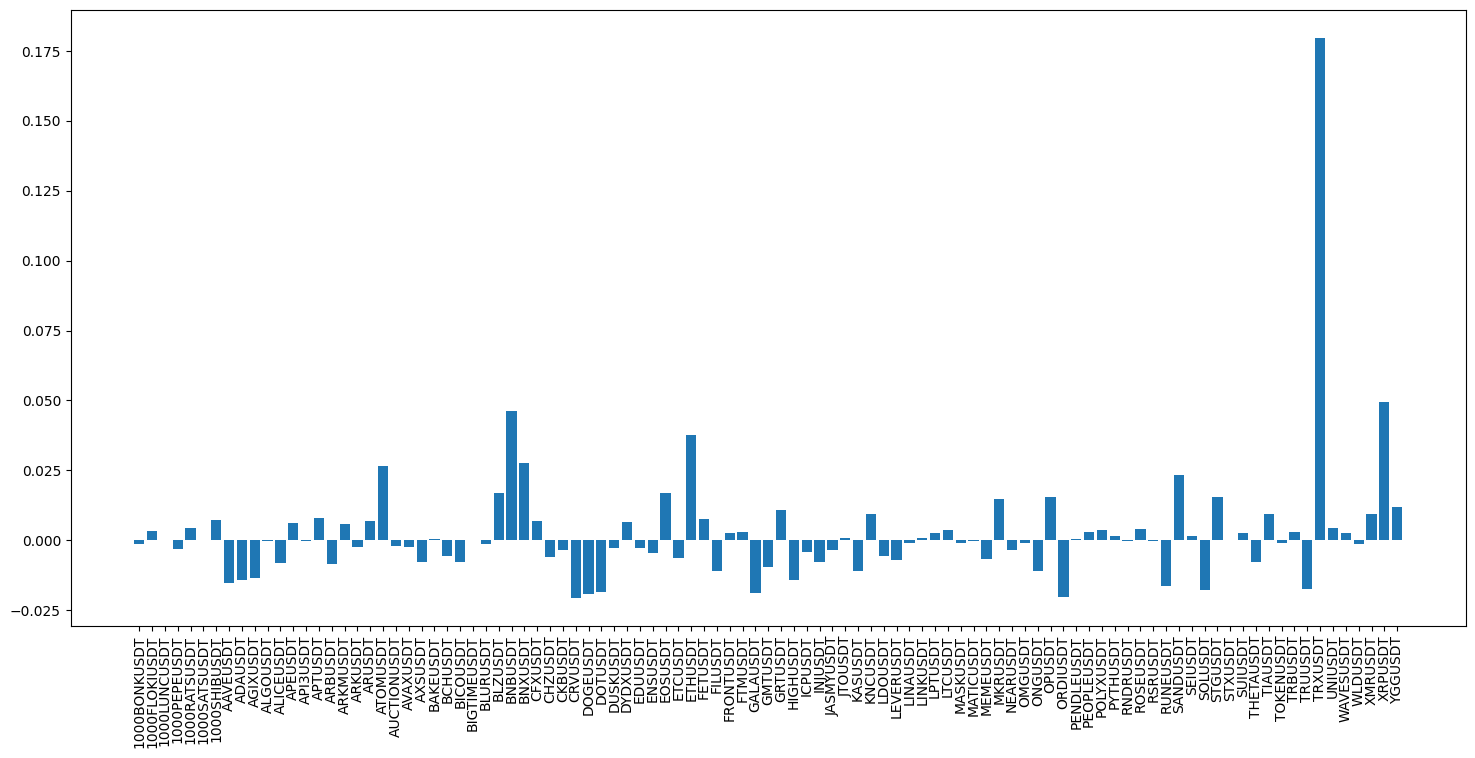

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
plt.bar(w.index, w.values)
plt.xticks(rotation = 90);

In [33]:
weights_df = pd.DataFrame(w, columns=['weights'], index=w.index)
weights_df.head()


,weights
1000BONKUSDT,-0.001141
1000FLOKIUSDT,0.003247
1000LUNCUSDT,0.000210
1000PEPEUSDT,-0.003071
1000RATSUSDT,0.004430


# 4. Rolling Portfolio Beta over test period (Assume rebalance every day)

### Optimization Function

In [34]:
def optimize_beta_neutral_portfolio(cov_matrix, mkt_betas, lower_bound: float, upper_bound: float) -> pd.DataFrame:
    n = cov_matrix.shape[1]
    weights = cp.Variable(n)
    pf_var = cp.quad_form(weights, cov_matrix.values)
    objective = cp.Minimize(pf_var)

    constraints = [
        weights >= lower_bound, 
        weights <= upper_bound, 
        weights.T @ mkt_betas == 0,
        # cp.abs(weights) <= 0.2,
        cp.sum(weights) == 1
    ]

    prob = cp.Problem(objective, constraints)
    if not prob.is_dcp():
        raise Exception("Problem is not DCP")

    prob.solve(solver=cp.CLARABEL)
    if prob.status != cp.OPTIMAL:
        raise Exception("Optimization problem is not solvable")

    weights = weights.value

    sum_weights = np.sum(np.abs(weights))
    weights = weights / sum_weights

    w = pd.Series(weights, index=cov_matrix.columns).to_frame(name='weights')

    return w

In [39]:
# rolling covariance matrix starting from the test data
rolling_cov = full_return_df.rolling(window=500).cov().dropna()
rolling_cov.head()

1000BONKUSDT  1000FLOKIUSDT  1000LUNCUSDT  \
open_ts                                                                        
2024-03-24 00:00:00 1000BONKUSDT       0.000992       0.000581      0.000359   
                    1000FLOKIUSDT      0.000581       0.001129      0.000320   
                    1000LUNCUSDT       0.000359       0.000320      0.000485   
                    1000PEPEUSDT       0.000656       0.000773      0.000304   
                    1000RATSUSDT       0.000557       0.000492      0.000343   

                                   1000PEPEUSDT  1000RATSUSDT  1000SATSUSDT  \
open_ts                                                                       
2024-03-24 00:00:00 1000BONKUSDT       0.000656      0.000557      0.000407   
                    1000FLOKIUSDT      0.000773      0.000492      0.000377   
                    1000LUNCUSDT       0.000304      0.000343      0.000267   
                    1000PEPEUSDT       0.000996      0.000513      0.000386   
                    1000RATSUSDT       0.000513      0.000949      0.000536   

                                   1000SHIBUSDT  AAVEUSDT   ADAUSDT  AGIXUSDT  \
open_ts                                                                         
2024-03-24 00:00:00 1000BONKUSDT       0.000487  0.000216  0.000274  0.000247   
                    1000FLOKIUSDT      0.000514  0.000203  0.000230  0.000261   
                    1000LUNCUSDT       0.000274  0.000174  0.000184  0.000213   
                    1000PEPEUSDT       0.000484  0.000219  0.000244  0.000251   
                    1000RATSUSDT       0.000449  0.000228  0.000244  0.000261   

                                   ...  TOKENUSDT   TRBUSDT   TRUUSDT  \
open_ts                            ...                                  
2024-03-24 00:00:00 1000BONKUSDT   ...   0.000368  0.000283  0.000288   
                    1000FLOKIUSDT  ...   0.000574  0.000263  0.000278   
                    1000LUNCUSDT   ...   0.000323  0.000233  0.000208   
                    1000PEPEUSDT   ...   0.000452  0.000241  0.000255   
                    1000RATSUSDT   ...   0.000392  0.000314  0.000291   

                                    TRXUSDT   UNIUSDT  WAVESUSDT   WLDUSDT  \
open_ts                                                                      
2024-03-24 00:00:00 1000BONKUSDT   0.000061  0.000200   0.000289  0.000258   
                    1000FLOKIUSDT  0.000055  0.000221   0.000249  0.000278   
                    1000LUNCUSDT   0.000046  0.000170   0.000202  0.000215   
                    1000PEPEUSDT   0.000058  0.000223   0.000274  0.000240   
                    1000RATSUSDT   0.000064  0.000189   0.000247  0.000308   

                                    XMRUSDT   XRPUSDT   YGGUSDT  
open_ts                                                          
2024-03-24 00:00:00 1000BONKUSDT   0.000095  0.000183  0.000216  
                    1000FLOKIUSDT  0.000114  0.000159  0.000185  
                    1000LUNCUSDT   0.000091  0.000130  0.000163  
                    1000PEPEUSDT   0.000119  0.000170  0.000166  
                    1000RATSUSDT   0.000108  0.000171  0.000220  

[5 rows x 100 columns]

In [40]:
# rolling optimization
dates = set(rolling_cov.index.get_level_values(0))
weights = pd.DataFrame(index=pd.Index(dates).sort_values(), columns = test_return_df.columns)
betas = pd.DataFrame(index=pd.Index(dates).sort_values(), columns = test_return_df.columns)

for dt in dates:
    full_cov = rolling_cov.loc[dt]
    final_cov = full_cov.drop('BTCUSDT').drop('BTCUSDT', axis=1)
    final_beta = full_cov['BTCUSDT'].drop('BTCUSDT') / full_cov.loc['BTCUSDT', 'BTCUSDT']
    
    weight_result = optimize_beta_neutral_portfolio(final_cov, final_beta, -1, 1)
    weights.loc[dt, :] = weight_result['weights']
    betas.loc[dt, :] = final_beta

In [46]:
weights.drop('BTCUSDT', axis=1, inplace=True)
betas.drop('BTCUSDT', axis=1, inplace=True)

In [47]:
portfolio_beta = (weights.shift(1) * betas).dropna().sum(axis=1)
portfolio_beta.head()

2024-03-24 04:00:00   -0.000017
2024-03-24 08:00:00   -0.000301
2024-03-24 12:00:00   -0.000012
2024-03-24 16:00:00    -0.00005
2024-03-24 20:00:00    0.000074
dtype: object

Text(0.5, 1.0, 'Mkt Neutral Portfolio Rolling Beta to Market')

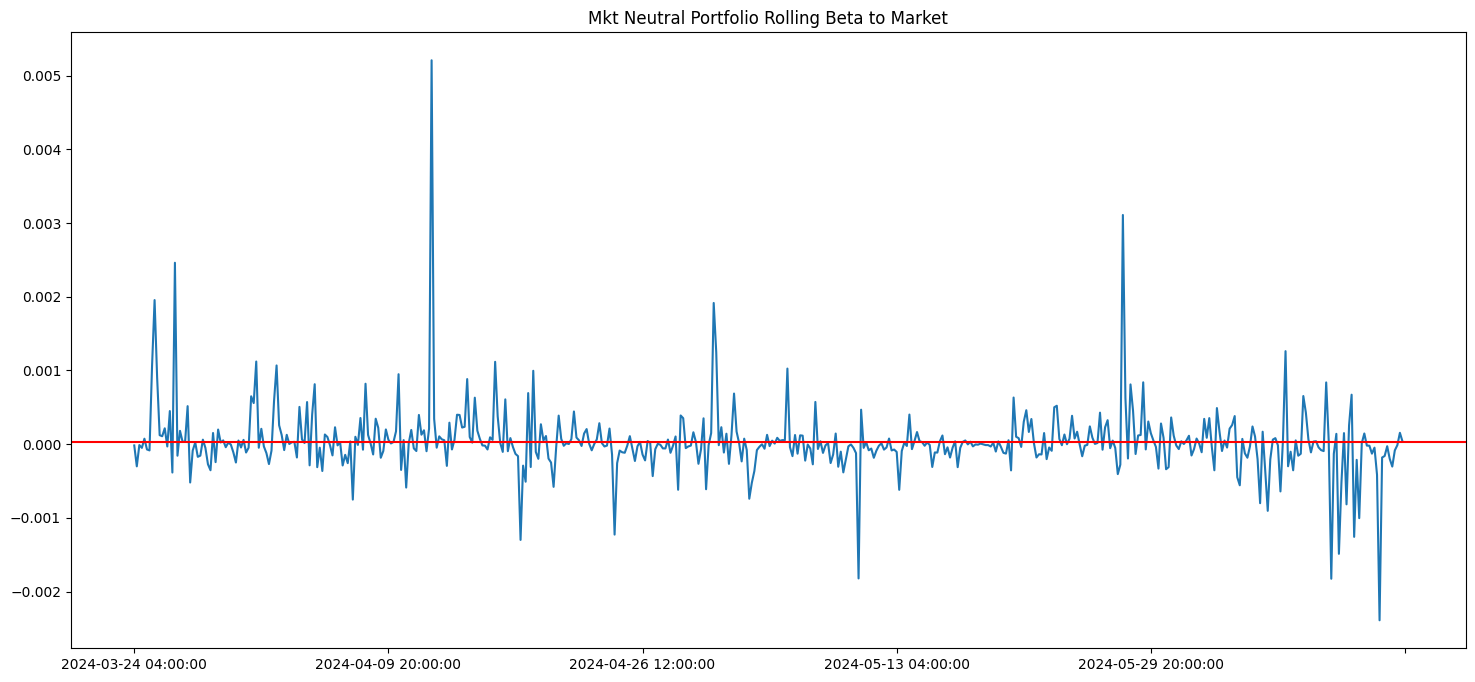

In [48]:
portfolio_beta.plot(figsize=(18, 8))
plt.axhline(portfolio_beta.mean(), color="red")
plt.title("Mkt Neutral Portfolio Rolling Beta to Market")

Text(0.5, 1.0, 'Backtest of Market Neutral Portfolio Return')

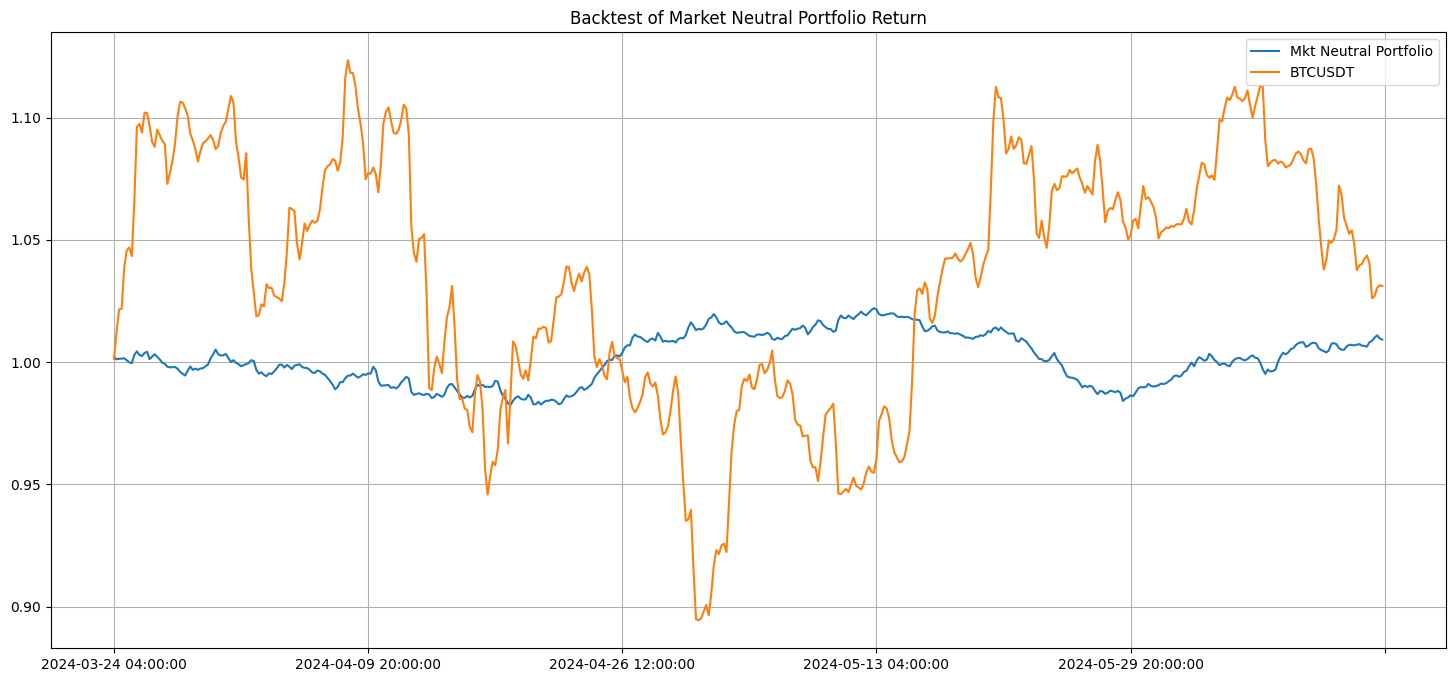

In [51]:
# process the order of the weights and test_return_df are the same
weights = weights.T.sort_index().T
test_return_df = test_return_df.T.sort_index().T.drop('BTCUSDT', axis=1)
# test_return_df = test_return_df.T.sort_index().T


portfolio_ret = (weights.shift(1) * test_return_df).dropna().sum(axis=1)
(1 + portfolio_ret).cumprod().plot(figsize=(18, 8), label="Mkt Neutral Portfolio")
(1 + full_return_df.loc[portfolio_ret.index].BTCUSDT).cumprod().plot()
plt.grid()
plt.legend()
plt.title("Backtest of Market Neutral Portfolio Return")